МФТИ: Data Mining in Action (осень, 2016)

* Дмитрий Персиянов, <dmitry.persiyanov@gmail.com>, https://vk.com/persiyanov
* Арсений Ашуха, <ars.ashuha@gmail.com>, https://vk.com/ars.ashuha

<h1 align='center'>Домашнее задание №1: линейные модели, бустинг</h1>

**Дополнительный материал для выполнения дз**:

*Линейные модели*:
- Лекция 2, DMIA: https://goo.gl/luURTu
- Логистическая регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/
- Линейная регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LinearRegression/

*Бустинг*:
- Hastie, The Elements of Statistical Learning, https://goo.gl/k3wfEU, 10 Boosting and Additive Trees 337
- Соколов, Семинары по композиционным методам, https://goo.gl/sn8RyJ, http://goo.gl/ajNTQy



**Оформление дз**: 
- Присылайте выполненное задание на почту ``datamininginaction@gmail.com``
- Укажите тему письма в следующем формате ``DMIA2016_fall <направление> <фамилия>_<имя> HW1``, к примеру -- ``DMIA2016_fall trends ivanov_ilya HW1``

**Вопросы**:
- Задавайте вопросы в issues на гитхабе: https://github.com/vkantor/MIPT_Data_Mining_In_Action_2016/issues
- Либо в группу или нам в личные сообщения: https://vk.com/data_mining_in_action
------------

<h1 align='center'>Overview</h1>

На последней лекции вы узнали про классические модели машинного обучения, которые каждый Data Scientist должен знать и понимать, как они работают.

В этом домашнем задании мы предлагаем вам реализовать две модели: одну линейную -- логистическую регрессию, и модель бустинга над деревьями, а также сравнить их качество на одном датасете.

-----------

<h1 align='center'>Part 1: Logistic Regression</h1>

In [1]:
# all import here
import pandas as pd
import numpy as np
import tqdm # interactive progress bar

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

from dmia_my.gradient_check import *
from dmia_my.classifiers import LogisticRegression
from sklearn.model_selection import train_test_split

from dmia_my.classifiers import BinaryBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from dmia_my.utils import plot_surface

%matplotlib inline

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

train_df = pd.read_csv('./data/train.csv')
review_summaries = list(train_df['Reviews_Summary'].values)
review_summaries = [l.lower() for l in review_summaries]

## 1. Знакомство с данными
Данные представляют собой выборку отзывов о еде с сайта Амазон. Для них проставлены метки -- положительный или отрицательный отзыв.

In [4]:
print train_df.shape

(110163, 3)


In [5]:
train_df.Prediction.value_counts(normalize=True)

0    0.50074
1    0.49926
Name: Prediction, dtype: float64

Видим, что классы сбалансированы. Можем оценивать качество модели по метрике ```accuracy```.

In [6]:
train_df.head()

,ID,Reviews_Summary,Prediction
0,239071,Michigan Cherries,1
1,466160,Great Product,1
2,397133,Ovaltine,1
3,297146,~,1
4,292685,Love it!,1


In [6]:
train_df.tail()

,ID,Reviews_Summary,Prediction
110158,486256,Terrible!,0
110159,199050,"Cheap Coffee, No Banana Flavor",0
110160,278179,Not as described,0
110161,87500,Tastes like a squirt of toothpaste mixed into ...,0
110162,121963,Disappointed,0


----------
## 2. Извлечение признаков
Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе. 

Для решения данной задачи вам необходимо написать код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация для решения задачи:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Используйте данный трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Помните, что все эти трансформеры возвращают ```sparse```-матрицы. Учитывая это и то, что линейные модели достаточно хорошо масштабируются на большое количество фич, можно смело ставить ```n_features``` 1000+.

Преобразуйте ```review_summaries``` с помощью ```TfidfVectorizer```.

In [17]:
print review_summaries[:5]

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(review_summaries)

y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print X.shape

['michigan cherries', 'great product', 'ovaltine', '~', 'love it!']
(110163, 1000)


## 3. Логистическая регрессия

Логистическая регрессия -- линейный классификатор, который очень часто используется на практике, например, в кредитном скоринге. Преимущества этой модели -- скорость обучения и предсказания (даже при сотнях тысяч фичей) а также интепретируемость: важные признаки имеют бОльшие по модулю веса. 

При этом отрицательные веса говорят, что фича важна для определения класса 0, а положительные -- для определения класса 1. Это можно понять, если вспомнить, что разделяющая поверхность линейных моделей, это $w^Tx = 0$, а значение алгоритма есть $a(x) = sign(w^Tx)$.

Будем предсказывать сентимент, подготовим данные и сделаем валидационную выборку. Вы ведь теперь знаете, что нужно оценивать качество модели не по обучающей выборке, а по валидационной. Иначе вы переобучитесь, когда будете тюнить гиперпараметры модели.

-----
** Реализуйте код в модуле ```dmia.classifiers.logistic_regression```.**

-----

## Gradient check

В этой ячейке вы можете проверить, правильно ли у вас все работает, прежде чем обучать модель на всех данных.

In [18]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: -0.000221 analytic: -0.000221, relative error: 3.540793e-08
numerical: -0.000171 analytic: -0.000171, relative error: 4.809969e-08
numerical: -0.000253 analytic: -0.000253, relative error: 1.117133e-08
numerical: -0.000163 analytic: -0.000163, relative error: 5.535925e-08
numerical: -0.000465 analytic: -0.000465, relative error: 6.512470e-09
numerical: -0.000082 analytic: -0.000082, relative error: 5.220790e-09
numerical: 0.000763 analytic: 0.000763, relative error: 7.186330e-09
numerical: -0.000445 analytic: -0.000445, relative error: 4.678704e-09
numerical: -0.000315 analytic: -0.000315, relative error: 9.718758e-09
numerical: -0.000054 analytic: -0.000054, relative error: 3.943390e-08


In [36]:
# data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

Обучите свою модель на ```X_train, y_train```.

Для начала можете взять параметры по умолчанию, и найти оптимальные используя валидацию.

In [32]:
clf = LogisticRegression()
clf.train(X_train, y_train, learning_rate=1, reg=0.001, num_iters=1000, verbose=True, batch_size=256)
print "Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test))

iteration 0 / 1000: loss 0.692555
iteration 100 / 1000: loss 0.602042
iteration 200 / 1000: loss 0.590224
iteration 300 / 1000: loss 0.585481
iteration 400 / 1000: loss 0.566884
iteration 500 / 1000: loss 0.576432
iteration 600 / 1000: loss 0.568747
iteration 700 / 1000: loss 0.616478
iteration 800 / 1000: loss 0.606570
iteration 900 / 1000: loss 0.621753
Train f1-score = 0.834
Test f1-score = 0.827


Нарисуем кривые обучения.

100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


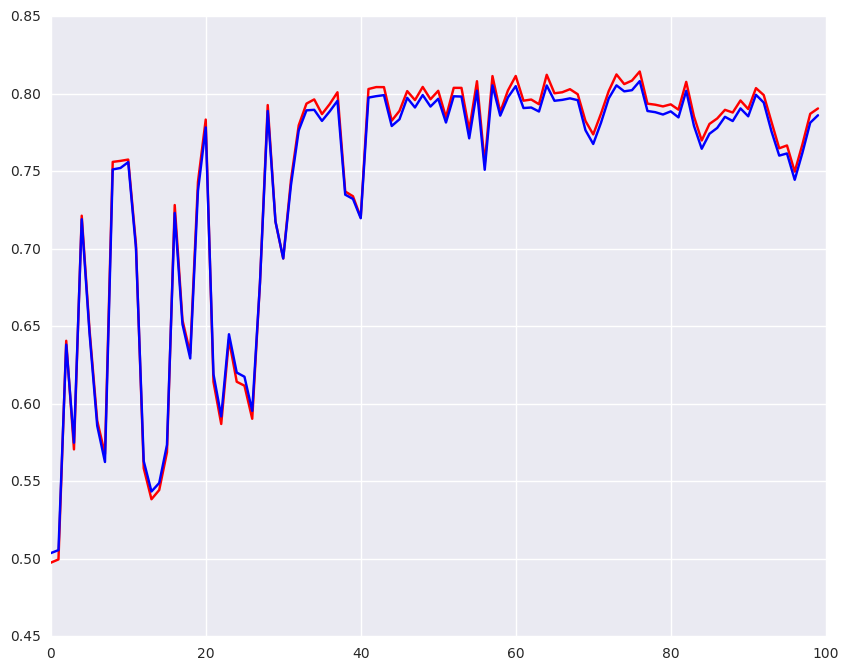

In [21]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 100
w = []

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1, reg=0.001, num_iters=1, batch_size=256)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))
    
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b', w, 'g')

## 4. Задание

* Обучите вашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведите первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедитесь, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 


* Топ позитивных фичей перечислите через запятую под пунктом 1 в письме с кодом.

* Топ негативных фичей перечислите через запятую под пунктом 1 в письме с кодом.


**Hint:** зная индекс фичи, само слово вы можете получить, используя метод ```vectorizer.get_feature_names()```.

**Hint:** ```np.argsort```.

In [22]:
# Получите индексы фичей
pos_features = np.argsort(clf.w)[-5:]
neg_features = np.argsort(clf.w)[:5]
# Выведите слова
print pd.Series(vectorizer.get_feature_names())[pos_features].values
print pd.Series(vectorizer.get_feature_names())[neg_features].values

[u'excellent' u'delicious' u'love' u'best' u'great']
[u'not' u'disappointed' u'too' u'bad' u'terrible']


## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучите такую же модель, но из пакета ```sklearn.linear_model``` и убедитесь, что ваша имплементация ничем не хуже (ну или почти не хуже).

In [24]:
clf = linear_model.LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train accuracy = 0.871
Test accuracy = 0.866


## 6. Что дальше?
* Нам повезло, что классы в нашем датасете сбалансированы. Какие проблемы возникнут у логистической регрессии, если, скажем, будет 90% нулевого класса и 10% первого. Как нужно изменить код, чтобы исправить эту проблему? Постарайтесь придумать не менее 2х способов.
* Почему мы не делаем регуляризацию для bias term в весах? Может, все таки, в каких-то случаях ее стоит делать?

Ответы на вопросы напишите здесь.

1) Если в выборке 90% нулевого класса и 10% первого, то алгоритм, выдающий константный ответ 0 обладает высокой accuracy 0.9. Поэтому классы нужно балансировать. Также можно использовать другую функцию потерь, которая не чувствительна к дисбалансу классов.
2) 

-----
<h1 align='center'>Part 2: Boosting</h1>

### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 


$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Как в итоге обучать**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ $g_{i-1} = \frac{\partial L(\sum_{j=0}^{i-1} a_j b_j(x))}{\partial y}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$
    - Подбираем $a_i$ -- одномерной минимизацией 
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + a_i b_i(x)$

## 1. Simple test

-----
** Реализуйте код в модуле ```dmia.classifiers.binary_boosting```.**

-----

In [73]:
# test data
X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)
print pd.Series(y).value_counts()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

-1.0    252
 1.0    248
dtype: int64


In [2]:
# real data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
# !!!!! labels to {-1, 1} !!!!!!!
y_train, y_test = 2*(y_train-0.5), 2*(y_test-0.5)

## 2. Outliers

In [3]:
%%time
# y_train must be in {-1, 1}
clf = BinaryBoostingClassifier(n_estimators=10, lr=1, max_depth=3, reg=0.5).fit(X_train, y_train)
# print clf.gamma
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))
# plot_surface(X_train, y_train, clf)

# сравнение со стандартным градиентным бустингом
clf0 = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3)
clf0.fit(X_train, y_train)
print "Train accuracy = %.3f" % accuracy_score(y_train, clf0.predict(X_train.toarray()))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf0.predict(X_test.toarray()))

Train accuracy = 0.773
Test accuracy = 0.768
Train accuracy = 0.697
Test accuracy = 0.692
CPU times: user 11.7 s, sys: 326 ms, total: 12.1 s
Wall time: 12 s


Посмотрим на выбросы.

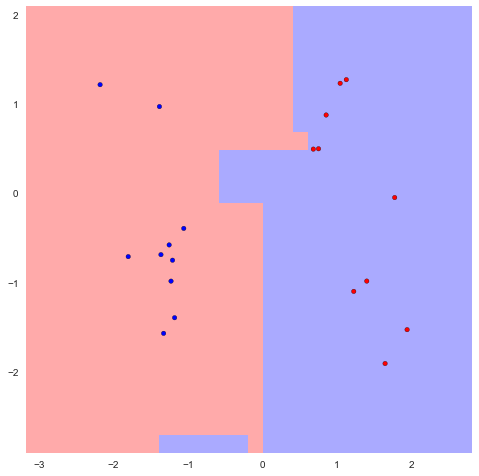

In [107]:
# not implemented
# outliers_indices = clf.out_
# plot_surface(X[outliers_indices], y[outliers_indices], clf)

## 3. Sentiment

Вы обучали логистическую регрессию на 1000+ фичах и это было быстро.

Как вы думаете, разумно ли обучать бустинг над деревьями на 1000 фичах? А на 10000? 100000? Обоснуйте ответ в каждом случае. Если не разумно, то что можно предпринять?

Ответ напишите ниже.

Бустинг обучается дольше, чем линейная регрессия. Для ускорения можно предварительно осуществить отбор фич. Либо использовать xgboost на многопроцессорной системе, т.к. он поддерживает распараллеливание.

In [48]:
clf = BinaryBoostingClassifier(n_estimators=1, max_depth=3).fit(X_train, y_train)

print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train accuracy = 0.497
Test accuracy = 0.504


## 4. Посмотрим на ```feature_importances_```

* Обучите бустинг **на всех данных**, обработав ```review_summaries``` с помощью ```TfidfVectorizer``` с ```max_features=1000```.

* Параметры модели возьмите ```lr=0.1, n_estimators=100, max_depth=3```.

* Найдите топ-10 самых важных фичей с точки зрения алгоритма.

* Перечислите эти 10 слов через запятую под пунктом 3 в своем письме с кодом.

In [42]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidfed = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
y = 2*(y-0.5)
# n_estimators=100 takes 50 minutes
clf = BinaryBoostingClassifier(n_estimators=10, max_depth=3)
clf.fit(tfidfed, y)

BinaryBoostingClassifier(lr=0.1, max_depth=None, n_estimators=10, reg=0)

In [43]:
print np.sort(clf.feature_importances_)[-10:]
print pd.Series(vectorizer.get_feature_names())[np.argsort(clf.feature_importances_)[-10:]].values

[ 0.1520617   0.22377297  0.22908567  0.39630554  0.412385    0.45309349
  0.5531825   0.78603532  1.22001826  1.7767044 ]
[u'but' u'yummy' u'bad' u'excellent' u'good' u'delicious' u'love' u'best'
 u'great' u'not']


## 5. Сравнение с sklearn.ensemble.GradientBoostingClassifier

Обучите градиентный бустинг из ```sklearn``` и сравните его качество на ```X_test``` с вашим.

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf = ...

In [ ]:
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))